In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import AutoModel, AutoTokenizer, AutoConfig
import re
import pandas as pd
from tqdm import tqdm
import os
from collections import Counter
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from peft import get_peft_model, LoraConfig, TaskType


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/asap-2-0/ASAP2_train_sourcetexts.csv
/kaggle/input/persuade-2-0/persuade_corpus_1.0.csv
/kaggle/input/persuade-2-0/persuade_2.0_human_scores_demo_id_github.csv
/kaggle/input/persuade-2-0/AES2-persuade.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/all_data.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/holistic_scores.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_ell.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_arguments.csv
/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/ell.csv


In [ ]:
class DebertaRegressor(nn.Module):
    def __init__(self, model_name="microsoft/deberta-v3-base"):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.deberta = AutoModel.from_pretrained(model_name, config=self.config)
        self.regressor = nn.Linear(self.config.hidden_size, 1)
        self.base_model = self.deberta

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
        return (token_embeddings * input_mask_expanded).sum(1) / input_mask_expanded.sum(1)

    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        pooled_output = self.mean_pooling(outputs, attention_mask)
        score = self.regressor(pooled_output)
        return score.squeeze(-1)




class EssayDataset(Dataset):
    def __init__(self, texts, scores, tokenizer, weights=None, max_length=512):
        self.texts = texts
        self.scores = scores
        self.weights = weights
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        score = self.scores[idx]

        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        input_ids = tokens["input_ids"].squeeze(0)
        attention_mask = tokens["attention_mask"].squeeze(0)

        item = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "score": torch.tensor(score, dtype=torch.float)
        }

        if self.weights is not None:
            item["weight"] = torch.tensor(self.weights[idx], dtype=torch.float)

        return item




def train_epoch(model, dataloader, optimizer, device):
    model.train()
    all_preds = []
    all_targets = []

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        scores = batch["score"].to(device)

        optimizer.zero_grad()
        predictions = model(input_ids=input_ids, attention_mask=attention_mask)
        weights = batch["weight"].to(device)
        loss = torch.mean(weights * (predictions - scores) ** 2)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        all_preds.extend(predictions.detach().cpu().numpy())
        all_targets.extend(scores.detach().cpu().numpy())

        progress_bar.set_postfix(loss=loss.item())

    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)

    metrics = {
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

    return metrics


def evaluate(model, dataloader, device):
    model.eval()
    predictions_list = []
    targets_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            scores = batch["score"].to(device)

            preds = model(input_ids=input_ids, attention_mask=attention_mask)

            predictions_list.extend(preds.cpu().numpy())
            targets_list.extend(scores.cpu().numpy())

    predictions_array = np.array(predictions_list)
    targets_array = np.array(targets_list)

    mse = mean_squared_error(targets_array, predictions_array)
    mae = mean_absolute_error(targets_array, predictions_array)
    r2 = r2_score(targets_array, predictions_array)

    metrics = {
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

    return metrics, predictions_list, targets_list



def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)              
    text = re.sub(r'https?://\S+|www\.\S+', '', text) 
    text = re.sub(r"[^a-z0-9.,!?'\s]", ' ', text)      
    text = re.sub(r'\s+', ' ', text).strip()           
    return text


def load_dataset(scale_scores=True, min_len=30):

    df1 = pd.read_csv("/kaggle/input/asap-2-0/ASAP2_train_sourcetexts.csv") 
    df2 = pd.read_csv("/kaggle/input/persuade-2-0/persuade_2.0_human_scores_demo_id_github.csv")
    df3 = pd.read_csv("/kaggle/input/persuade-2-0/AES2-persuade.csv")
    df4 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/all_data.csv")
    df5 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/holistic_scores.csv")
    df6 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_ell.csv")
    df7 = pd.read_csv("/kaggle/input/persuade-corpus-and-ellipse-corpus-combined/scores_arguments.csv")

 
    for df in [df2, df4, df5, df6, df7]:
        df.rename(columns={'holistic_essay_score': 'score'}, inplace=True)

  
    df = pd.concat([
        df1[['full_text', 'score']],
        df2[['full_text', 'score']],
        df3[['full_text', 'score']],
        df5[['full_text', 'score']],
        df6[['full_text', 'score']],
        df7[['full_text', 'score']]
    ], ignore_index=True)


    if scale_scores:
        scaler_main = MinMaxScaler()
        df['score'] = scaler_main.fit_transform(df[['score']])

        scaler_df4 = MinMaxScaler()
        df4['score'] = scaler_df4.fit_transform(df4[['score']])  


    df = pd.concat([
        df[['full_text', 'score']],
        df4[['full_text', 'score']]
    ], ignore_index=True)


    df = df.dropna(subset=['full_text', 'score'])
    df = df.drop_duplicates(subset='full_text').reset_index(drop=True)


    df = df.sample(frac=1, random_state=42).reset_index(drop=True)


    df = df[df['full_text'].str.strip() != ""]
    df['essay'] = df['full_text'].apply(clean_text)
    df = df[df['essay'].str.split().apply(len) >= min_len]
    df = df[['essay', 'score']]

    return df

def save_structured_output(texts, predictions, targets, output_prefix="structured_output"):
    structured_data = []

    for i in range(len(texts)):
        item = {
            "essay_id": i,
            "essay_text": texts[i],
            "predicted_score": round(float(predictions[i]), 2),
            "actual_score": float(targets[i])
        }
        structured_data.append(item)

    
    with open(f"{output_prefix}.json", "w", encoding="utf-8") as f_json:
        json.dump(structured_data, f_json, indent=4)

def compute_score_weights(scores, num_bins=20):
    binned_scores = pd.qcut(scores, q=num_bins, duplicates='drop')
    bin_counts = Counter(binned_scores)
    bin_weights = {k: 1.0 / v for k, v in bin_counts.items()}
    weights = binned_scores.map(bin_weights).values
    return weights

In [120]:
df = load_dataset()


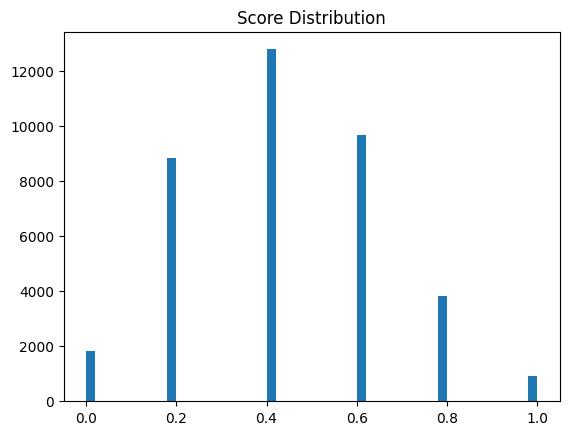

In [161]:
import matplotlib.pyplot as plt
plt.hist(df['score'], bins=50)
plt.title("Score Distribution")
plt.show()


In [ ]:
df['score'] = df['score'].apply(lambda x: 0.20 if x == 0.25 else x)

weights = compute_score_weights(df['score'])
df['weight'] = weights

In [ ]:
df

,essay,score,weight
0,whether it's being on a sports team or taking ...,0.4,0.000078
1,driving and phones phones and driving have bee...,0.4,0.000078
2,space exploration is a growing topic. nasa has...,0.6,0.000103
3,some schools offer students the choice of lear...,1.0,0.001073
4,smart cars can be very helpful in many ways. b...,0.6,0.000103
...,...,...,...
37887,a car that you do not have to drive. it sounds...,0.6,0.000103
37888,thomas haung made a new technology called the ...,0.2,0.000094
37889,the case of the driveless cars how many movies...,0.6,0.000103
37890,"according to the article, i support the author...",0.0,0.000094


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

In [ ]:
base_model = DebertaRegressor().to(device)

peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION  ,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query_proj", "key_proj", "value_proj"]
)


model = get_peft_model(base_model, peft_config).to(device)

In [130]:
train_texts,test_texts, train_labels, test_labels = train_test_split(
    df["essay"], df["score"],
    test_size=0.2, random_state=42, stratify=df["score"]
)

train_dataset = EssayDataset(train_texts.reset_index(drop=True), train_labels.reset_index(drop=True), tokenizer,df["weight"])
test_dataset = EssayDataset(test_texts.reset_index(drop=True), test_labels.reset_index(drop=True), tokenizer)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

In [134]:
if __name__ == "__main__":
    b_metrics, b_predictions, b_targets = evaluate(base_model, test_loader, device)
    print("Before Training Metrics:", b_metrics)
    for epoch in range(1):
        print(f"Epoch: {epoch+1}")
        metrics = train_epoch(model, train_loader, optimizer, device)
        print("Training Metrics:", metrics)
        a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
        print("After Training Metrics:", a_metrics)

Before Training Metrics: {'MSE': 0.32246643, 'MAE': 0.52664673, 'R2': -5.36838691824615}
Epoch: 1


Training Metrics: {'MSE': 0.032705754, 'MAE': 0.1363714, 'R2': 0.3543008451821288}


After Training Metrics: {'MSE': 0.020623788, 'MAE': 0.113199286, 'R2': 0.5927009609303081}


In [137]:
for epoch in range(4):
    print(f"Epoch: {epoch+1}")
    metrics = train_epoch(model, train_loader, optimizer, device)
    print("Training Metrics:", metrics)
    a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
    print("After Training Metrics:", a_metrics)

Epoch: 1


Training Metrics: {'MSE': 0.018446852, 'MAE': 0.10634191, 'R2': 0.6358097812669602}


After Training Metrics: {'MSE': 0.019403454, 'MAE': 0.10998999, 'R2': 0.6168013675584072}
Epoch: 2


Training Metrics: {'MSE': 0.017203774, 'MAE': 0.1025111, 'R2': 0.6603514758122164}


After Training Metrics: {'MSE': 0.01714507, 'MAE': 0.10270574, 'R2': 0.6614022020082075}
Epoch: 3


Training Metrics: {'MSE': 0.016488796, 'MAE': 0.1005318, 'R2': 0.6744670370896738}


After Training Metrics: {'MSE': 0.01637261, 'MAE': 0.10012179, 'R2': 0.6766574613950649}
Epoch: 4


Training Metrics: {'MSE': 0.015890744, 'MAE': 0.09857491, 'R2': 0.6862741976009965}


After Training Metrics: {'MSE': 0.016029477, 'MAE': 0.09938726, 'R2': 0.6834339802593296}


In [162]:
for epoch in range(4):
    print(f"Epoch: {epoch+1}")
    metrics = train_epoch(model, train_loader, optimizer, device)
    print("Training Metrics:", metrics)
    a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
    print("After Training Metrics:", a_metrics)

Epoch: 1


Training Metrics: {'MSE': 0.0153782815, 'MAE': 0.097080044, 'R2': 0.6963915681585666}


After Training Metrics: {'MSE': 0.015491789, 'MAE': 0.09763971, 'R2': 0.6940527731513617}
Epoch: 2


Training Metrics: {'MSE': 0.015073175, 'MAE': 0.09606682, 'R2': 0.7024151831253045}


After Training Metrics: {'MSE': 0.015270889, 'MAE': 0.09720195, 'R2': 0.698415338959707}
Epoch: 3


Training Metrics: {'MSE': 0.014742737, 'MAE': 0.095160805, 'R2': 0.7089389253495115}


After Training Metrics: {'MSE': 0.015275694, 'MAE': 0.09746956, 'R2': 0.6983204169435275}
Epoch: 4


Training Metrics: {'MSE': 0.0145828, 'MAE': 0.09452417, 'R2': 0.7120964987293911}


After Training Metrics: {'MSE': 0.014822302, 'MAE': 0.095586106, 'R2': 0.7072744860001138}


In [167]:
for epoch in range(3):
    print(f"Epoch: {epoch+1}")
    metrics = train_epoch(model, train_loader, optimizer, device)
    print("Training Metrics:", metrics)
    a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
    print("After Training Metrics:", a_metrics)

Epoch: 1


Training Metrics: {'MSE': 0.014435273, 'MAE': 0.09416952, 'R2': 0.7150090801005146}


After Training Metrics: {'MSE': 0.014640672, 'MAE': 0.0946707, 'R2': 0.7108614947120124}
Epoch: 2


Training Metrics: {'MSE': 0.014301731, 'MAE': 0.09369821, 'R2': 0.7176455405571247}


After Training Metrics: {'MSE': 0.014648863, 'MAE': 0.0947328, 'R2': 0.7106997031025842}
Epoch: 3


Training Metrics: {'MSE': 0.014151326, 'MAE': 0.093339555, 'R2': 0.7206149469185641}


After Training Metrics: {'MSE': 0.014370523, 'MAE': 0.09409412, 'R2': 0.7161966520231365}


In [174]:
for epoch in range(2):
    print(f"Epoch: {epoch+1}")
    metrics = train_epoch(model, train_loader, optimizer, device)
    print("Training Metrics:", metrics)
    a_metrics, a_predictions, a_targets = evaluate(model, test_loader, device)
    print("After Training Metrics:", a_metrics)

Epoch: 1


Training Metrics: {'MSE': 0.014072696, 'MAE': 0.09309355, 'R2': 0.7221673043324939}


After Training Metrics: {'MSE': 0.014298517, 'MAE': 0.093902364, 'R2': 0.7176186926517852}
Epoch: 2


Training Metrics: {'MSE': 0.013953876, 'MAE': 0.09267935, 'R2': 0.7245131424677712}


After Training Metrics: {'MSE': 0.014334895, 'MAE': 0.0942332, 'R2': 0.7169002882165522}


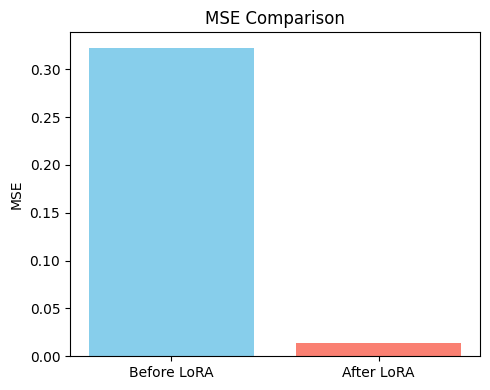

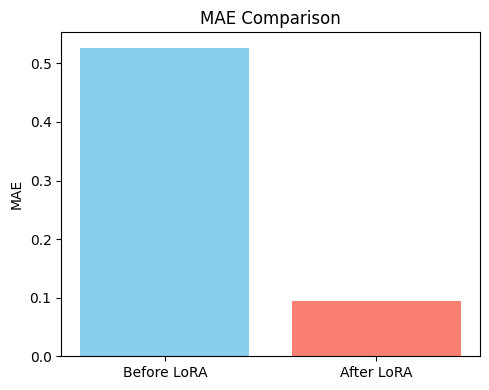

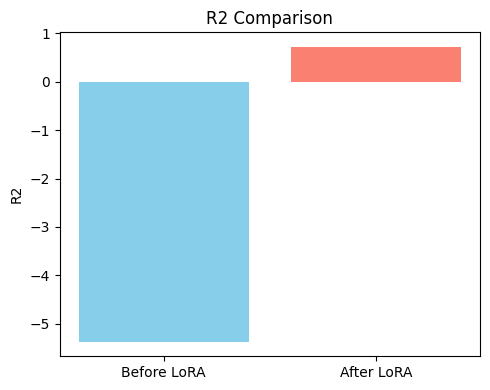

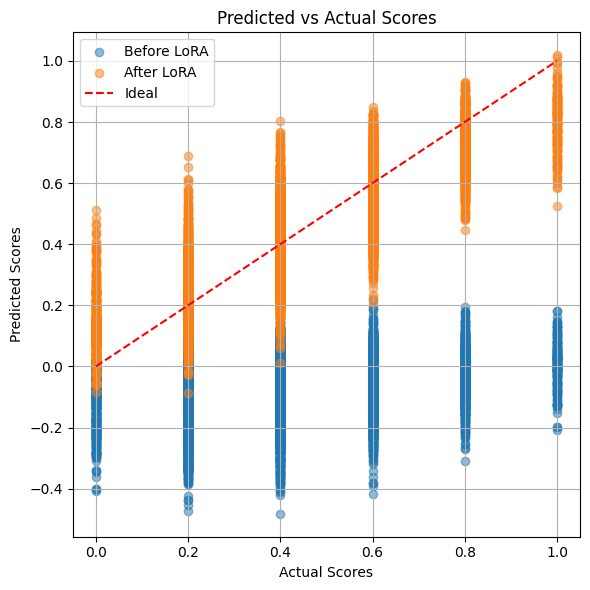

In [ ]:
metrics_to_plot = ['MSE', 'MAE', 'R2']
b_values = [b_metrics[m] for m in metrics_to_plot]
a_values = [a_metrics[m] for m in metrics_to_plot]

for i, metric in enumerate(metrics_to_plot):
    plt.figure(figsize=(5, 4))
    plt.bar(['Before LoRA', 'After LoRA'], [b_values[i], a_values[i]], color=['skyblue', 'salmon'])
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(b_targets, b_predictions, alpha=0.5, label="Before LoRA")
plt.scatter(a_targets, a_predictions, alpha=0.5, label="After LoRA")
min_val = min(min(b_targets), min(a_targets))
max_val = max(max(b_targets), max(a_targets))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal")
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Scores")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [176]:
save_structured_output(test_texts.tolist(), a_predictions, a_targets, output_prefix="model_output_V1")

In [ ]:
def generate_feedback_based_on_prediction(predicted_score):
    if predicted_score >= 0.6:
        overall = "This essay is strong overall, showing excellent organization, development of ideas, and clarity in expression."
        strengths = "Ideas are well-structured, arguments are persuasive, and language use is mostly mature and accurate."
        improvements = "Polish minor grammar issues and ensure transitions are smooth to reach perfection."
    elif predicted_score >= 0.3:
        overall = "This essay is moderately effective, with some clear ideas but also noticeable issues in structure or grammar."
        strengths = "The essay communicates a clear message and shows effort in supporting ideas with examples."
        improvements = "Focus on improving sentence structure, grammar, and the logical flow between paragraphs."
    else:
        overall = "This essay is underdeveloped and difficult to follow, with significant issues in structure and language."
        strengths = "The attempt to engage with the topic is visible."
        improvements = "Focus on organizing your thoughts clearly, using proper grammar, and fully developing your main ideas."

    return {
        "overall_evaluation": overall,
        "strengths": strengths,
        "areas_for_improvement": improvements
    }

with open("model_output_V1.json", "r", encoding="utf-8") as f:
    essays = json.load(f)

for essay in essays:
    pred = essay.get("predicted_score", 0.0)
    essay["feedback"] = generate_feedback_based_on_prediction(pred)

with open("model_final_outputs.json", "w", encoding="utf-8") as f:
    json.dump(essays, f, indent=4, ensure_ascii=False)

print("Feedback based on predicted score saved to 'model_final_outputs.json'.")

Feedback based on predicted score saved to 'model_final_outputs.json'.
